# Understanding the Amazon from space

In [1]:
#importing required libraries
import numpy as np
import pandas as pd
import gc
from tqdm import tqdm
import cv2
import os

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint

import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread
from PIL import Image

from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split



In [2]:
!ls ../input/planets-dataset/planet/planet

sample_submission.csv  test-jpg  train-jpg  train_classes.csv


In [3]:
#Load train and test dataset
train_path = '../input/planets-dataset/planet/planet/train-jpg/'
test_path = '../input/planets-dataset/planet/planet/test-jpg/'
train_dataset = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')
submission_path = os.path.join('../input/planets-dataset/planet/planet/sample_submission.csv')

In [4]:
#reading the labels
df = train_dataset

print(df.shape)

(40479, 2)


In [5]:
#peak into the dataset
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


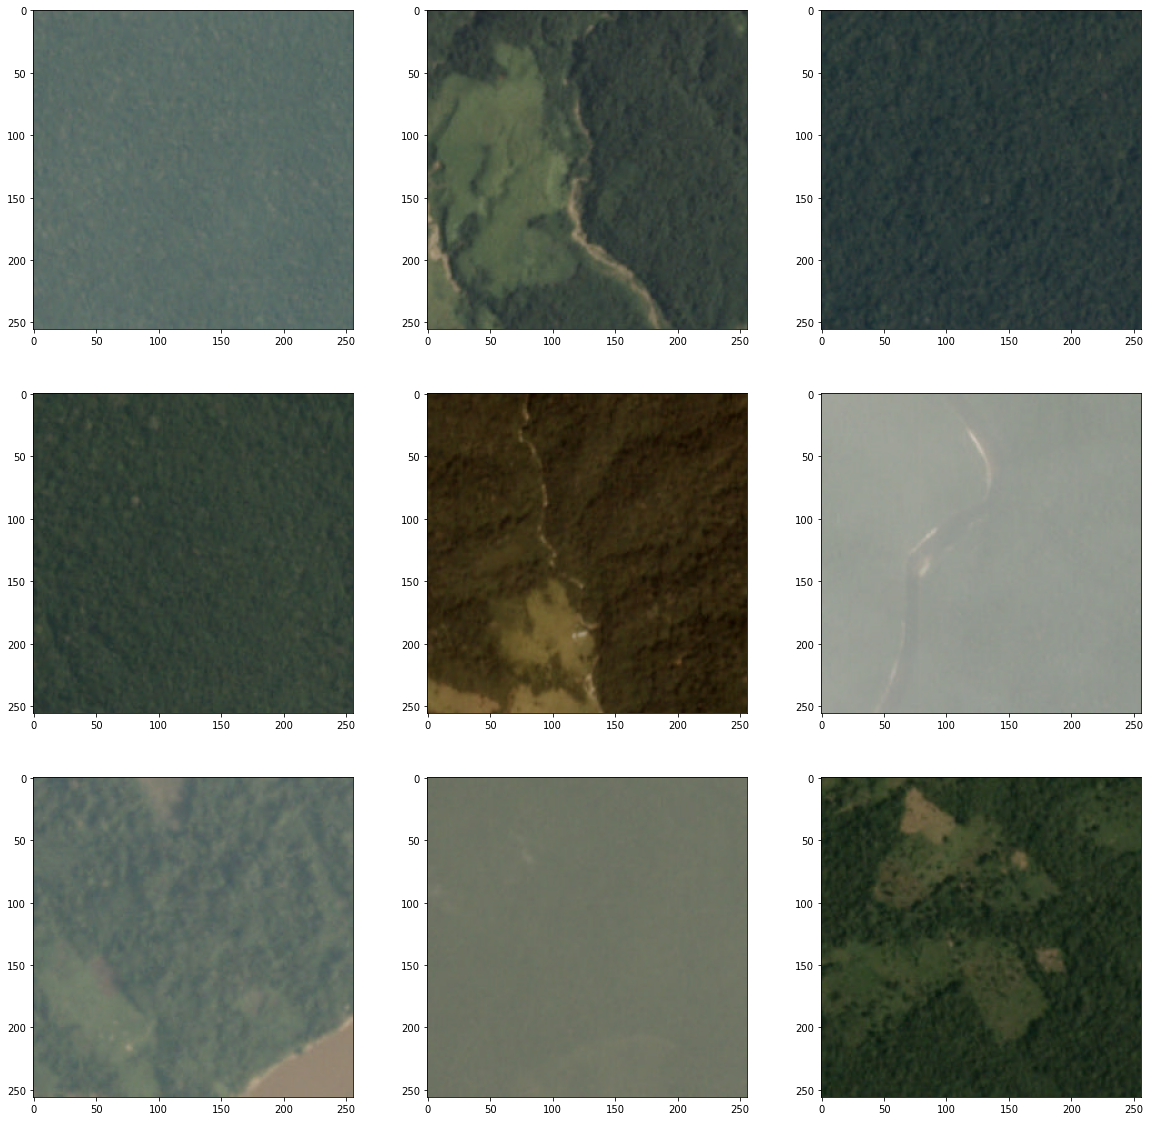

In [6]:
plt.figure(figsize=( 20 , 20 ))

folder = 'planet/train-jpg/'

for i in range(9):
    pyplot.subplot(330 + 1 + i)
    
    # Define File
    file = train_path + 'train_' + str(i) + '.jpg'
    
    # Load image pixel
    image = imread(file)
    
    # Plot pixel data
    pyplot.imshow(image)
    
plt.show()

In [7]:
# Removing individual tags from df by splitting with empty strings
label_list = []
for tag_split in df.tags.to_numpy():
    labels = tag_split.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)
print(len(label_list))

17


In [8]:
label_list.sort()

labels_dict = dict(zip(range(0,17), label_list))
labels_dict

{0: 'agriculture',
 1: 'artisinal_mine',
 2: 'bare_ground',
 3: 'blooming',
 4: 'blow_down',
 5: 'clear',
 6: 'cloudy',
 7: 'conventional_mine',
 8: 'cultivation',
 9: 'habitation',
 10: 'haze',
 11: 'partly_cloudy',
 12: 'primary',
 13: 'road',
 14: 'selective_logging',
 15: 'slash_burn',
 16: 'water'}

In [9]:
# Creating a one-hot encoding for the features
for label in label_list:
    df[label] = df['tags'].apply(lambda x: 1 if label in x.split() else 0)
    
df.head(3)

,image_name,tags,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,train_0,haze primary,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train_1,agriculture clear primary water,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train_2,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


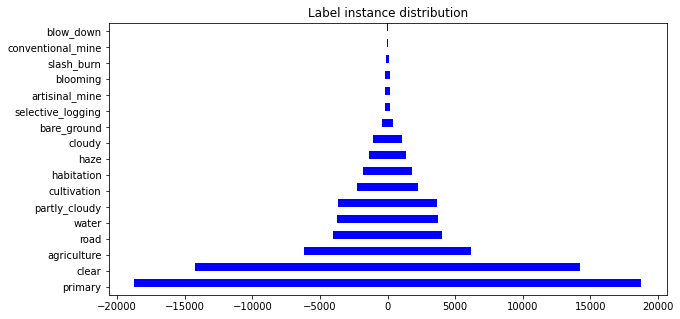

In [10]:
# Ploting the labels      
df[label_list].sum().sort_values(ascending=False)\
.plot(kind='barh', title='Label instance distribution', orientation= 'vertical', figsize=(10, 5), color='blue')
plt.show()

In [11]:
# columns after tag and image_name
df_columns = list(df.columns[2:])

In [12]:
# Onehotencode the image name
df['image_name'] = df['image_name'].apply(lambda x: f'{x}.jpg')
df.head(3)

,image_name,tags,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,train_0.jpg,haze primary,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train_1.jpg,agriculture clear primary water,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train_2.jpg,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [13]:
# Creating and evaluating the Fscore metric
def f_beta_score(y_true, y_pred, beta = 2, epsilon = 1e-4):
    
    beta_squared = beta**2
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    fn = tf.reduce_sum(y_true, axis = 1) - tp
    
    precision = tp/(tp +fp +epsilon)
    recall = tp/(tp + fn + epsilon)
    
    return (1 + beta_squared) * precision * recall / (beta_squared * precision + recall + epsilon)


In [14]:
def accuracy_score(y_true, y_pred, epsilon = 1e-4):
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    fn = tf.reduce_sum(y_true, axis = 1) - tp
    
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)
        
    tn = tf.reduce_sum(tf.cast(tf.logical_not(y_true), tf.float32) * tf.cast(tf.logical_not(y_pred), tf.float32), 
                       axis = 1)
    return (tp + tn)/(tp + tn + fp + fn + epsilon)

In [15]:
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

# train_set contains 80 percent of images
train_gen = train_datagen.flow_from_dataframe(dataframe=df,
                                              directory = train_path,  
                                              x_col="image_name", 
                                              y_col=df_columns, 
                                              subset="training", 
                                              batch_size=128,
                                              seed=42, 
                                              shuffle = True, 
                                              class_mode="raw", 
                                              target_size=(128,128))


# val_set contains 20 percent of images 
val_gen = train_datagen.flow_from_dataframe(dataframe=df,
                                            directory = train_path,  
                                            x_col="image_name", 
                                            y_col=df_columns, 
                                            subset="validation", 
                                            batch_size=128,
                                            seed=42, 
                                            shuffle = True, 
                                            class_mode="raw", 
                                            target_size=(128,128))

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [16]:
# Batchsize for training and validation set
train_steps = train_gen.n // train_gen.batch_size
val_steps = val_gen.n // train_gen.batch_size

In [17]:
def model_building():
    model = Sequential()
    model.add(BatchNormalization(input_shape=(128, 128, 3)))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='sigmoid'))
    
    return model

In [18]:
model = model_building()

2023-01-17 08:17:35.802770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 08:17:35.803824: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 08:17:36.054296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 08:17:36.055111: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 08:17:36.055940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        3

In [20]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[f_beta_score, accuracy_score])

# Save the callback
callback = EarlyStopping(
    monitor="val_loss", 
    patience=2,
    verbose=0,
    baseline=None,
    restore_best_weights=True,
)

In [21]:
gc.collect()

30454

In [22]:
history = model.fit(x=train_gen,
                    steps_per_epoch=train_steps,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=10,
                    callbacks=[callback]) 

2023-01-17 08:17:43.111430: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2023-01-17 08:17:47.720467: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


253/253 [==============================] - 411s 2s/step - loss: 0.2316 - f_beta_score: 0.6821 - accuracy_score: 0.9116 - val_loss: 0.2243 - val_f_beta_score: 0.6960 - val_accuracy_score: 0.9130
Epoch 2/10
253/253 [==============================] - 148s 586ms/step - loss: 0.1707 - f_beta_score: 0.7767 - accuracy_score: 0.9338 - val_loss: 0.1537 - val_f_beta_score: 0.7889 - val_accuracy_score: 0.9395
Epoch 3/10
253/253 [==============================] - 138s 547ms/step - loss: 0.1536 - f_beta_score: 0.7989 - accuracy_score: 0.9396 - val_loss: 0.1394 - val_f_beta_score: 0.8127 - val_accuracy_score: 0.9448
Epoch 4/10
253/253 [==============================] - 138s 545ms/step - loss: 0.1432 - f_beta_score: 0.8134 - accuracy_score: 0.9435 - val_loss: 0.1328 - val_f_beta_score: 0.8174 - val_accuracy_score: 0.9468
Epoch 5/10
253/253 [==============================] - 140s 555ms/step - loss: 0.1357 - f_beta_score: 0.8255 - accuracy_score: 0.9463 - val_loss: 0.1238 - val_f_beta_score: 0.8470 - v

In [23]:
import gc
gc.collect()

33

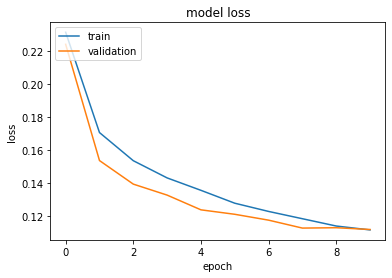

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [25]:
# Test data: divide the submission dataframe into two splits as the image names after 40669 is different 
submission_df = pd.read_csv(submission_path)
test_df = submission_df.iloc[:40669]['image_name'].reset_index().drop('index', axis =1)

In [26]:
test_df['image_name'] = submission_df['image_name'].apply(lambda x: '{}.jpg'.format(x))
test_df.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [27]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_gen = test_datagen.flow_from_dataframe(dataframe=test_df,
                                            directory = test_path,  
                                            x_col="image_name", 
                                            y_col=None, 
                                            batch_size=67,
                                            shuffle=False,
                                            class_mode=None, 
                                            target_size=(128,128))

test_size = test_gen.n // test_gen.batch_size

Found 40669 validated image filenames.


In [28]:
pred = model.predict(test_gen, steps=test_size, verbose=1)

607/607 [==============================] - 387s 636ms/step


In [29]:
test_names = test_gen.filenames 
        
test_result = pd.DataFrame(pred)
test_result = test_result.apply(lambda x: ' '.join(np.array(label_list)[x >= 0.2]), axis=1)

test_result_df = pd.DataFrame({'image_name': test_names, 'tags': test_result})
test_result_df.head()

,image_name,tags
0,test_0.jpg,clear primary
1,test_1.jpg,clear primary
2,test_2.jpg,partly_cloudy primary
3,test_3.jpg,agriculture clear cultivation primary
4,test_4.jpg,cloudy partly_cloudy primary


In [30]:
# additional batch of the test dataset
additional_df = submission_df.iloc[40669:]['image_name'].reset_index().drop('index', axis=1)
additional_df['image_name'] = additional_df['image_name'].apply(lambda x: '{}.jpg'.format(x))
additional_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [31]:
additional_gen = test_datagen.flow_from_dataframe(dataframe=additional_df,
                                                  directory="../input/planets-dataset/test-jpg-additional/test-jpg-additional", 
                                                  x_col='image_name',
                                                  y_col = None,
                                                  batch_size=62,
                                                  shuffle=False,
                                                  class_mode=None, 
                                                  target_size=(128, 128))
additional_step = additional_gen.n // additional_gen.batch_size

Found 20522 validated image filenames.


In [32]:
# predicted probabilities for each class
pred_additional = model.predict(additional_gen, steps=additional_step, verbose=1)

331/331 [==============================] - 194s 584ms/step


In [33]:
additional_names = additional_gen.filenames 
        
additional_result = pd.DataFrame(pred_additional)
additional_result = additional_result.apply(lambda x: ' '.join(np.array(label_list)[x >= 0.2]), axis=1)

additional_result_df = pd.DataFrame({'image_name': additional_names, 'tags': additional_result})
additional_result_df.head()

,image_name,tags
0,file_0.jpg,clear primary
1,file_1.jpg,agriculture partly_cloudy primary road
2,file_10.jpg,agriculture haze primary road water
3,file_100.jpg,agriculture clear primary water
4,file_1000.jpg,clear primary


In [34]:
final_result = pd.concat([test_result_df, additional_result_df])

final_result = final_result.reset_index().drop('index', axis =1)

final_result

,image_name,tags
0,test_0.jpg,clear primary
1,test_1.jpg,clear primary
2,test_2.jpg,partly_cloudy primary
3,test_3.jpg,agriculture clear cultivation primary
4,test_4.jpg,cloudy partly_cloudy primary
...,...,...
61186,file_9995.jpg,cloudy partly_cloudy primary
61187,file_9996.jpg,clear primary water
61188,file_9997.jpg,clear primary water
61189,file_9998.jpg,cloudy


In [35]:
# Remove the .jpg extension from the image_name of the final_result
final_result['image_name'] = final_result['image_name'].apply(lambda x: x[:-4])
final_result

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,agriculture clear cultivation primary
4,test_4,cloudy partly_cloudy primary
...,...,...
61186,file_9995,cloudy partly_cloudy primary
61187,file_9996,clear primary water
61188,file_9997,clear primary water
61189,file_9998,cloudy


In [36]:
# save the results to a CSV file save and set the index to false.
final_result.to_csv('submission.csv', index=False)